## Подготовка

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

Загрузим данные и посмотрим, расположены ли они в хронологическом порядке.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.index.is_monotonic

True

Выведем общую информацию о датасете.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Определим границы временного диапазона данных.

In [4]:
data.index.max()

Timestamp('2018-08-31 23:50:00')

In [5]:
data.index.min()

Timestamp('2018-03-01 00:00:00')

Данные предоставлены от 2018-03-01 до 2018-08-31.

Проверим данные на наличие пропусков.

In [6]:
data.isna().sum()

num_orders    0
dtype: int64

Ресемплируем данные по одному часу.

In [7]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [8]:
data['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

Среднее количество заказов в час ~ 84, медианное - 78.

Посмотрим на тренд, сезонность и остатки.

In [9]:
decomposed = seasonal_decompose(data)

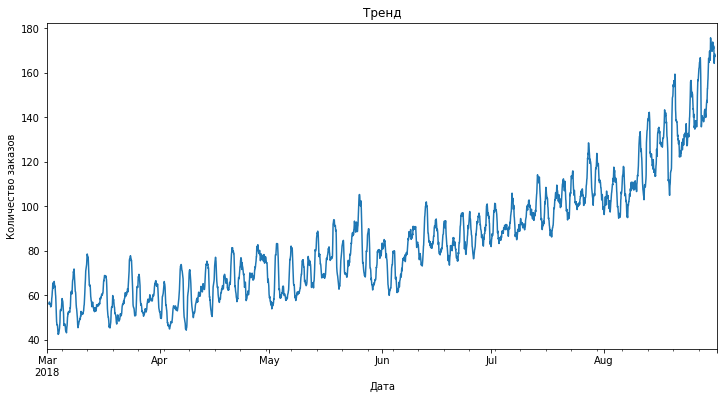

In [10]:
plt.figure(figsize=(12, 6))

ax = decomposed.trend.plot()
ax.set_title('Тренд');
ax.set_xlabel('Дата');
ax.set_ylabel('Количество заказов');

Наблюдается общий тренд на увеличение количества заказов.

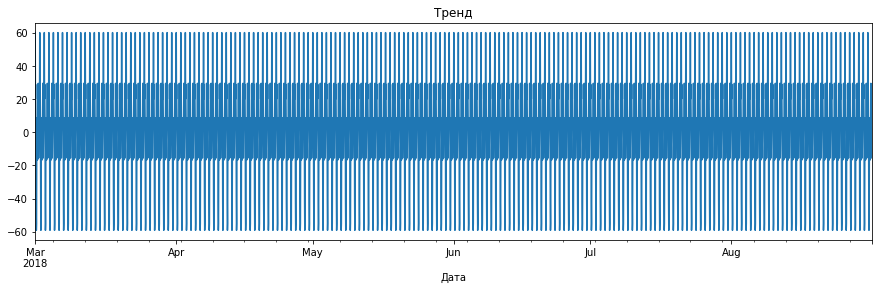

In [11]:
plt.figure(figsize=(15, 4))

ax = decomposed.seasonal.plot()
ax.set_title('Тренд');
ax.set_xlabel('Дата');

Так не ясно, сезонность на таком диапазоне данных сложно интерпретировать, поэтому рассмотрим ее на более коротком промежутке времени, например в рамках 1 месяца.

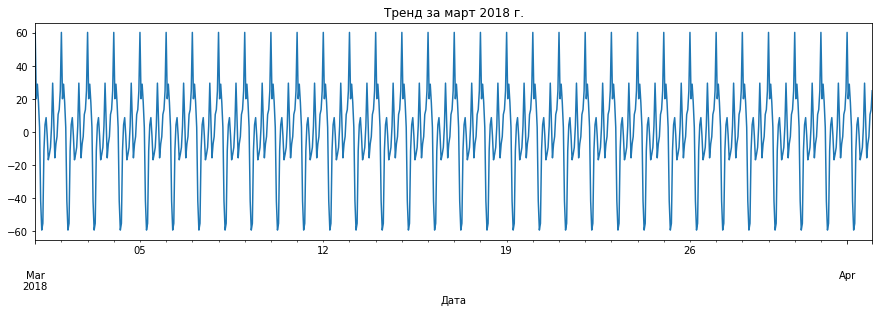

In [12]:
plt.figure(figsize=(15, 4))

ax = decomposed.seasonal['2018-03-01':'2018-04-01'].plot()
ax.set_title('Тренд за март 2018 г.');
ax.set_xlabel('Дата');

Оценим также тренд за сутки (для примера возьмем случайные 3 числа в за предоставленный период).

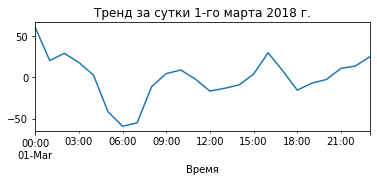

In [13]:
plt.figure(figsize=(6, 2))

ax = decomposed.seasonal['2018-03-01'].plot()
ax.set_title('Тренд за сутки 1-го марта 2018 г.');
ax.set_xlabel('Время');

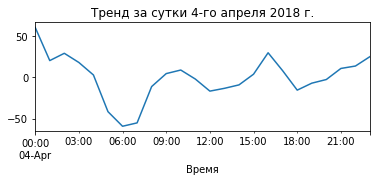

In [14]:
plt.figure(figsize=(6, 2))

ax = decomposed.seasonal['2018-04-04'].plot()
ax.set_title('Тренд за сутки 4-го апреля 2018 г.');
ax.set_xlabel('Время');

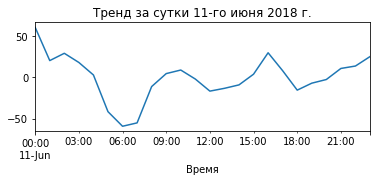

In [15]:
plt.figure(figsize=(6, 2))

ax = decomposed.seasonal['2018-06-11'].plot()
ax.set_title('Тренд за сутки 11-го июня 2018 г.');
ax.set_xlabel('Время');

Можем отметить тренд снижения количества заказов от полуночи до 6 утра, затем постепенное неравномерное увеличение в течение дня с дневным пиком в районе 16-17 часов.

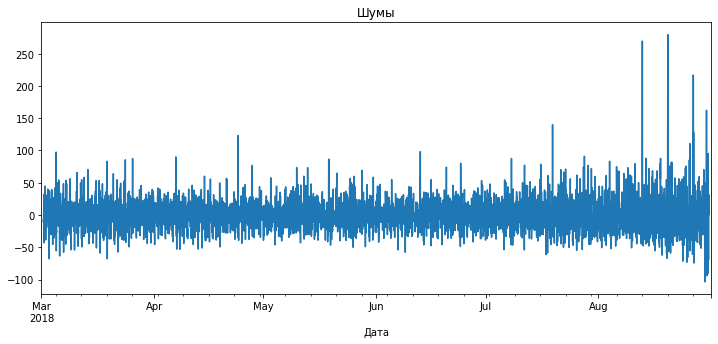

In [16]:
plt.figure(figsize=(12, 5))

ax = decomposed.resid.plot()
ax.set_title('Шумы');
ax.set_xlabel('Дата');

## Обучение

### Подготовим признаки

In [17]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [18]:
data = make_features(data, 20, 20)
data.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Разделим выборку 

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

### CatBoostRegressor

prediction_time, train_rmse_LR = fit_model(CatBoostRegressor(random_state=12345, verbose=False), 
            {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1, 1]}, 
            features_train, target_train, features_test, target_test)


{
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 2]
}

In [20]:
model = CatBoostRegressor(random_seed=12345, verbose=0)

tscv = TimeSeriesSplit(n_splits=5)

param_grid =  {'depth': [5, 6, 7, 9],
               'learning_rate': [0.1, 0.15]}


grid_catboost=GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv,
                          verbose=0)

grid_catboost.fit(X_train, y_train)

print('Гиперпараметры лучшей модели:', grid_catboost.best_params_)
print('RMSE лучшей модели на кросс-валидации:', -grid_catboost.best_score_)

Гиперпараметры лучшей модели: {'depth': 6, 'learning_rate': 0.1}
RMSE лучшей модели на кросс-валидации: 27.542311728779975


### LightGBM

In [21]:
model = lgb.LGBMRegressor(random_state=12345)

param_grid = param_grid = {
    'num_leaves': [80, 100, 150],
    'max_depth': [5, 6, 7, 9], 
    'learning_rate': [0.1, 0.2],
    'n_estimators': [150, 200, 300]
}

grid_lgb=GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=tscv,
                          verbose=0)

grid_lgb.fit(X_train, y_train)
print('Гиперпараметры лучшей модели:', grid_lgb.best_params_)
print('RMSE лучшей модели на кросс-валидации:', -grid_lgb.best_score_)

Гиперпараметры лучшей модели: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'num_leaves': 80}
RMSE лучшей модели на кросс-валидации: 27.794151561158365


По итогам обучения моделей и подбора их гиперпараметров, модель с лучшим RMSE после кросс-валидации - LGBMRegressor с параметрами {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 100, 'reg_lambda': 0}

## Тестирование

In [22]:
best_model = grid_lgb.best_estimator_
predictions = best_model.predict(X_test)

print(mean_squared_error(y_test, predictions)**0.5)

46.78881549960363


Значение RMSE на тестовой выборке составляет 54.4. Такое качество превосходит установленный заказчиком порог - менее 48. 